### 0. 코랩 구동을 위한 설정

###### 0.1 구글드라이브와 연동

In [1]:
from google.colab import drive
drive.mount('/content/workingdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/workingdrive


###### 0.2 모듈 설치

In [2]:
!pip install konlpy
!pip install pyLDAvis

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 12.1MB/s 
     |████████████████████████████████| 3.8MB 61.0MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 1.6MB 8.5MB/s 
     |████████████████████████████████| 552kB 41.6MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=21b642478756dd0930dcc6765ad3b47416ddbf62db0321629fd9276f5e631865
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=d5098beaa568181782b8c4fb4d82f7028dacf6712306fbe6a28a1c6a68cd71f7
  Stored in directory: /root/.cache/pip/whee

###### 0.3 모듈 불러오기

In [3]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import logging
import time
import datetime

from gensim.models import word2vec
from konlpy.tag import Okt
%matplotlib inline

from string import punctuation

import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import collections
import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
pip install -U gensim

     |████████████████████████████████| 24.2MB 131kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


#### 0.4 맷플롯립을 위한 폰트 설정

In [5]:
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

In [6]:
plt.rc('font', family='NanumBarunGothic')

### 1. 데이터 로드 및 확인

In [7]:
bill_df = pd.read_csv('/content/workingdrive/My Drive/Colab Notebooks/data/bill_total.csv')
print(bill_df.shape)
bill_df.head()

(25908, 41)


,의안번호,처리여부,의안명,제안자구분,제안일자,의결일자,의결결과,심사진행상태,문서,제안회기,제안이유,소관위원회,제안자,제안정당,법률안,법률공포여부,개혁보수신당,국민의당,기본소득당,대안신당,대한애국당,더불어민주당,더불어시민당,무소속,미래를향한전진4.0,미래통합당,미래한국당,민생당,민주평화당,민중당,바른미래당,바른정당,새누리당,새로운보수당,새민중정당,시대전환,열린민주당,우리공화당,자유한국당,정의당,의안명+제안이유
0,2024996,처,집합건물의 소유 및 관리에 관한 법률 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,NaN,의안원문,제20대 (2016~2020) 제378회,아파트 등 공동주택은 공동주택관리법 에 의해 체계적으로 관리되고 있는 반면 주상...,법제사법위원회,"[""['김병관(더불어민주당/金炳官)'"", "" '고용진(더불어민주당/高榕禛)'"", ""...",['더불어민주당'],1.0,미공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,집합건물의 소유 및 관리에 관한 법률 일부개정법률안 아파트 등 공동주택은 공동주택...
1,2024995,처,지방세법 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,NaN,의안원문\r\n비용추계서 미첨부 사유서,제20대 (2016~2020) 제378회,법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 해마다 부동산 가격공시...,행정안전위원회,"[""['김병관(더불어민주당/金炳官)'"", "" '김철민(더불어민주당/金哲玟)'"", ""...",['더불어민주당'],1.0,미공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,지방세법 일부개정법률안 법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 ...
2,2024994,처,법률용어 정비를 위한 정보위원회 소관 개 법률 일부개정을 위한 법률안,위원장,2020-05-20,2020-05-20,원안가결,NaN,의안원문,제20대 (2016~2020) 제378회,NaN,정보위원회,"[""['김민기(더불어민주당/金敏基)']""]",['더불어민주당'],1.0,공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,법률용어 정비를 위한 정보위원회 소관 개 법률 일부개정을 위한 법률안
3,2024993,처,진실 화해를 위한 과거사정리 기본법 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,NaN,의안원문,제20대 (2016~2020) 제378회,NaN,행정안전위원회,"[""['전혜숙(더불어민주당/全惠淑)']""]",['더불어민주당'],1.0,공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,진실 화해를 위한 과거사정리 기본법 일부개정법률안
4,2024992,처,화재예방 소방시설 설치 유지 및 안전관리에 관한 법률 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,NaN,의안원문,제20대 (2016~2020) 제378회,NaN,행정안전위원회,"[""['전혜숙(더불어민주당/全惠淑)']""]",['더불어민주당'],1.0,공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,화재예방 소방시설 설치 유지 및 안전관리에 관한 법률 일부개정법률안


In [8]:
bill_df.columns

Index(['의안번호', '처리여부', '의안명', '제안자구분', '제안일자', '의결일자', '의결결과', '심사진행상태', '문서',
       '제안회기', '제안이유', '소관위원회', '제안자', '제안정당', '법률안', '법률공포여부', '개혁보수신당',
       '국민의당', '기본소득당', '대안신당', '대한애국당', '더불어민주당', '더불어시민당', '무소속',
       '미래를향한전진4.0', '미래통합당', '미래한국당', '민생당', '민주평화당', '민중당', '바른미래당', '바른정당',
       '새누리당', '새로운보수당', '새민중정당', '시대전환', '열린민주당', '우리공화당', '자유한국당', '정의당',
       '의안명+제안이유'],
      dtype='object')

In [9]:
## 분석의 편의를 위해 분석일자, 의결일자를 연-월 로 변경
time_list = []
for i in bill_df['제안일자']:
  time = i.split('-')[0] + '-' + i.split('-')[1]
  time_list.append(time)

bill_df['제안일자(Y-M)'] = time_list

In [10]:
bill_df.columns
bill_df.drop(['처리여부', '의결결과', '심사진행상태', '문서', '의결일자', '제안자', '법률안', '제안일자'], axis=1, inplace=True)

## 2. 최저임금 관련 키워드 뽑아내기

>1) 법안에서 '최저임금'이라는 단어 의안명+제안이유에 들어간 법안 뽑아내기  
2) word2vec을 이용하여 '최저임금'과 유사성이 높은 단어 뽑아내기  
3) '최저임금'과 유사성이 높은 단어가 의안명+제안이유 들어간 법안 뽑아내기 

#### 2.1  법안에서 '최저임금'이라는 단어 의안명+제안이유에 들어간 법안 뽑아내기

In [11]:
keyword = r'.*(최저 임금|최저임금).*'
min_rage = bill_df[bill_df['의안명'].str.match(keyword) | bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
print(min_rage.shape)

(231, 34)


#### 2.2 word2vec을 이용하여 '최저임금'과 유사성이 높은 단어 뽑아내기

In [12]:
# 한글 전처리
def preprocessing(text): 
  text = re.sub('\\\\n', ' ', text)
  text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
  return text

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근',
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄'
              '중','게','너무','자','이런','때','되지','위해','에는','없는',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
             '마련','있도록','또는','함','하도록','개월','부터','제호','관','되고','년','월','및','등','안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [13]:
%time contents = bill_df['의안명+제안이유'].apply(preprocessing)

CPU times: user 727 ms, sys: 3.49 ms, total: 731 ms
Wall time: 731 ms


In [57]:
# 단어에서 명사만 뽑아내기
okt = Okt()
%time tokens = contents.apply(okt.nouns)
tokens[:3]

CPU times: user 12min 15s, sys: 1.2 s, total: 12min 16s
Wall time: 12min 14s


0    [집합, 건물, 소유, 및, 관리, 관, 법률, 일부, 개정, 법률, 안, 아파트,...
1    [지방, 세법, 일부, 개정, 법률, 안, 법, 아파트, 등, 주택, 대한, 재산세...
2    [법률용어, 정비, 위, 정보, 위원회, 소관, 개, 법률, 일부, 개정, 위, 법...
Name: 의안명+제안이유, dtype: object

In [58]:
# 명사들 중 불용어 제거
tokens_clean = tokens.apply(remove_stopword)

In [59]:
# word2vec 모델 학습에 로그를 찍을 수 있도록 합니다.

logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [60]:
# 모델 학습
model = word2vec.Word2Vec(tokens_clean, size=100, window=2, workers=4, min_count=10, iter=30, sg=1)

model

2020-08-30 12:39:14,185 : INFO : collecting all words and their counts
2020-08-30 12:39:14,187 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-30 12:39:14,414 : INFO : PROGRESS: at sentence #10000, processed 1089995 words, keeping 14511 word types
2020-08-30 12:39:14,650 : INFO : PROGRESS: at sentence #20000, processed 2202550 words, keeping 18457 word types
2020-08-30 12:39:14,812 : INFO : collected 19696 word types from a corpus of 2872994 raw words and 25908 sentences
2020-08-30 12:39:14,813 : INFO : Loading a fresh vocabulary
2020-08-30 12:39:14,844 : INFO : effective_min_count=10 retains 8877 unique words (45% of original 19696, drops 10819)
2020-08-30 12:39:14,845 : INFO : effective_min_count=10 leaves 2840956 word corpus (98% of original 2872994, drops 32038)
2020-08-30 12:39:14,876 : INFO : deleting the raw counts dictionary of 19696 items
2020-08-30 12:39:14,878 : INFO : sample=0.001 downsamples 37 most-common words
2020-08-30 12:39:14,879 : 

In [61]:
# 모델 이름을 지정하고 저장한다.
model_name = '1minwords'
model.save(model_name)

2020-08-30 12:43:17,065 : INFO : saving Word2Vec object under 1minwords, separately None
2020-08-30 12:43:17,067 : INFO : not storing attribute vectors_norm
2020-08-30 12:43:17,069 : INFO : not storing attribute cum_table
2020-08-30 12:43:17,180 : INFO : saved 1minwords


In [62]:
len(model.wv.vocab)

8877

In [63]:
vocab = model.wv.vocab

In [64]:
## '최저임금', '임금'과 같이 쓰이는 단어 목롬
print(model.wv.most_similar('최저임금'))
print(model.wv.most_similar('임금'))

2020-08-30 12:43:24,730 : INFO : precomputing L2-norms of word weight vectors


[('최저임금법', 0.7277185916900635), ('임금', 0.6882940530776978), ('고용노동부', 0.5714473724365234), ('일급', 0.5681016445159912), ('생활임금', 0.5540570616722107), ('근로시간', 0.5521740913391113), ('근로자', 0.5222100615501404), ('물가', 0.5215619802474976), ('월급', 0.5172407627105713), ('경제성장률', 0.5110524892807007)]
[('체불', 0.7685667276382446), ('최저임금', 0.6882940530776978), ('근로자', 0.6503157615661621), ('노동시간', 0.6006252765655518), ('최저임금법', 0.5995720028877258), ('근로기준법', 0.5984710454940796), ('불사', 0.5914668440818787), ('퇴직금', 0.5882185697555542), ('일급', 0.581613302230835), ('미지', 0.5811576247215271)]


키워드 __'최저임금'__으로만 토픽모델링을 진행해도 되지만 __최저임금과 관련된 추가적인 키워드__로 진행해도 더 많은 인사이트를 얻을 수 있을 것이라 기대.

1) 최초에는 '최저임금' 키워드로 토픽모델링  
2) 최저임금과 유사도가 높은 키워드 중 '최저임금법', '임금', '일급', '시급'을 키워드로 선정하여 토픽모델링 진행

#### 2.3 '최저임금'과 유사성이 높은 단어가 의안명+제안이유 들어간 법안 뽑아내기  

- word2vec을 통해 뽑아낸 '최저임금법', '임금', '일급', '시급'을 추가

In [113]:
keyword = r'.*(최저임금|임금|일급|시급|생활임금).*'
rage = bill_df[bill_df['의안명'].str.match(keyword) | bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
print(rage.shape)

(1130, 34)


## 3. 키워드 '최저임금' 분석

#### 3.1 법안은 언제 발의됐는가

In [14]:
rage_proposer_date = pd.DataFrame(min_rage.groupby('제안일자(Y-M)')['의안명'].count())
rage_proposer_date.head()

,의안명
제안일자(Y-M),
2016-06,6
2016-07,13
2016-08,13
2016-09,1
2016-10,4


Text(0.5, 1.0, '월별 최저임금 관련 법안 발의 건수')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


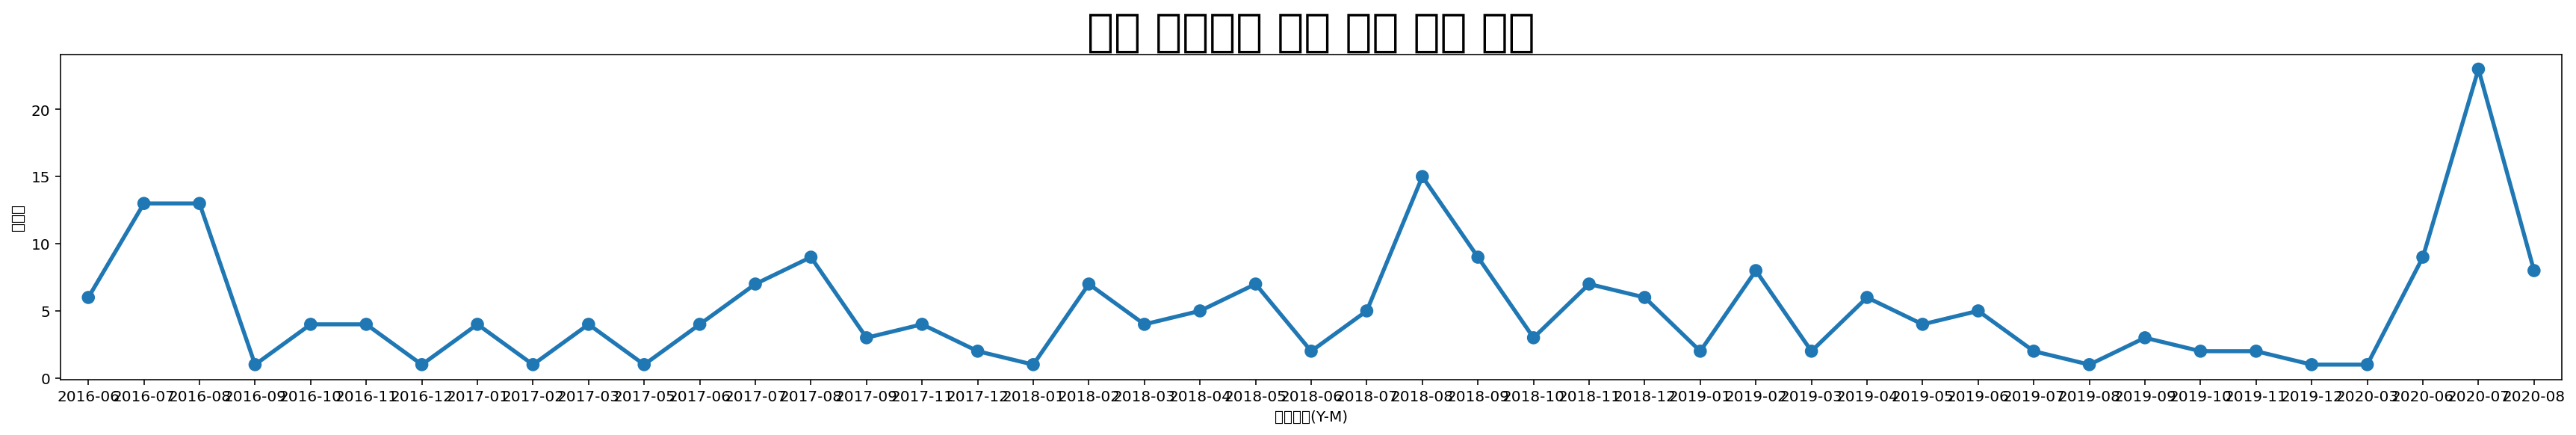

In [15]:
plt.figure(figsize = (30,4))
sns.pointplot(data = rage_proposer_date, x=rage_proposer_date.index, y='의안명')
plt.title('월별 최저임금 관련 법안 발의 건수', fontsize=30)

매 년 6~8월에 의안이 집중되는 경향이 있음 -> 혹시 최저임금 관련 법안이 아니더라도 법안 발의가 여름에 몰리는 것 아닐까?

Text(0.5, 1.0, '월별 법안 발의 건수')

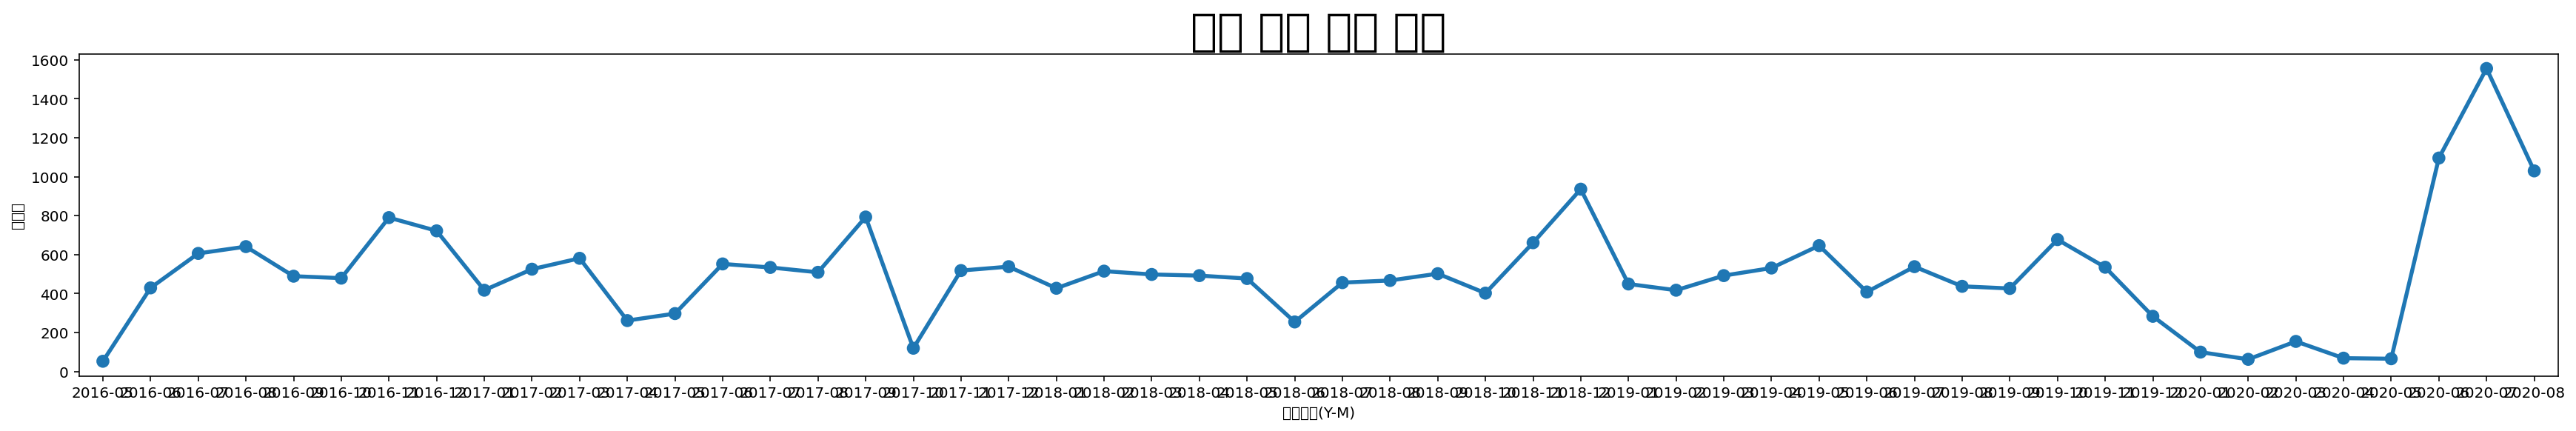

In [16]:
plt.figure(figsize = (30,4))

proposer_date = pd.DataFrame(bill_df.groupby('제안일자(Y-M)')['의안명'].count())
sns.pointplot(data = proposer_date, x=proposer_date.index, y='의안명')
plt.title('월별 법안 발의 건수', fontsize=30)

월별 법안발의 건수와 대동소이하나 __여름에 좀 더 집중__되는 경향이 보임  

최저임금은 매년 __8월 5일__ 최저임금위원회와 고용노동부에 의해 고시.  
최저임금과 관련된 특별한 사건에 의해 법안이 발의된다기 보다는 __최저임금이 결정되는 시기__를 전후로 법안을 발의하는 것으로 보임


#### 3.2 법안 토픽모델링

In [17]:
stopword_list = ['법률', '경우', '대한', '일부', '개정','것임', '관련','현행법','위원회','조의','국회법',\
                  '조제', '관련', '내용', '사항', '발생', '행위', '운영', '업무','이상', '신설', '규정',\
                  '해당', '기준', '마련', '설치', '사항', '대상', '또는', '있음', '대해', '대하', '거나']

In [18]:
           
###################### 텍스트전처리 ######################

def Preproc(textlist):

  ## 특수문자 제거 & 명사추출
  okt = Okt()
  cleanlist = []
  nounlist = []
  removedict = ['법률','경우','것임','대한','신설','규정','현행법','사업','지원','위원회','관리','국가','해당','발생','관련','사항','있음']
        
  for i in range(len(textlist)):
    n = re.sub('[-=.#/:$}·,■?]','',str(textlist[i]))
    k = re.sub('[0-9]','',n)
    nounlist.append(okt.nouns(k))
    
  for i in nounlist:
    for j in i:
      if len(j)==1:
        i.remove(j)
  for i in nounlist:
    for j in i:
      if j in removedict:
        i.remove(j)
  for i in nounlist:
    for j in i:
      if j in stopword_list:
        i.remove(j)

  cleanlist = nounlist
    
  return cleanlist

###################### 상위 50개 단어 제거 ######################


def remove_common(cleanlist):
  collections.Counter()

  flat=[]
  for i in cleanlist:
    for j in i:
      if (j not in stopword_list) or (len(j)!=1):
        flat.append(j)
                    
                    
  commoncount = collections.Counter(flat)
  commoncount = commoncount.most_common(50)

  newdict = []

  for i in range(len(commoncount)): #50
    newdict.append(commoncount[i][0])

  for i in cleanlist:
    if i in newdict:
      cleanlist.remove(i)
    
  return cleanlist, newdict

###################### 말뭉치 ######################

def make_corpus(cleanlist):

  dictionary = corpora.Dictionary(cleanlist)
  corpus = [dictionary.doc2bow(text) for text in cleanlist]
    
  return corpus, dictionary, cleanlist

###################### 토픽수최적화 ######################

def coh_visual(corpus, dictionary, cleanlist):
    
  coherence_values = []
    
  for i in range(2,20):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
    coherence_model_lda = CoherenceModel(model = ldamodel, texts = cleanlist, dictionary = dictionary, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    
  x = range(2,20)
  plt.plot(x, coherence_values)
  plt.xlabel('number of topics')
  plt.ylabel('coherence score')
  plt.show()
      
###################### 언어모델평가 ######################

def perp_visual(corpus, dictionary):
    
  perplexity_values = []
    
  for i in range(2,20):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
    perplexity_values.append(ldamodel.log_perplexity(corpus))
    
  x = range(2,20)
  plt.plot(x, perplexity_values)
  plt.xlabel('number of topics')
  plt.ylabel('perplexity score')
  plt.show()

In [19]:
## 최저임금 법안을 하나의 리스트로 만들기
min_rage_text_list = []
for i in min_rage['의안명+제안이유']:
  min_rage_text_list.append(i)

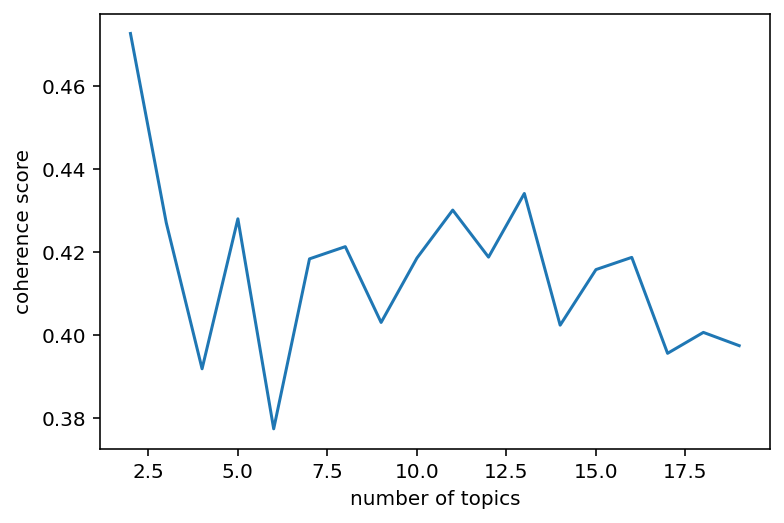

In [20]:
min_rage_clean = Preproc(min_rage_text_list)
min_rage_corpus, min_rage_dictionary, min_rage_cleanlist = make_corpus(min_rage_clean)
coh_visual(min_rage_corpus, min_rage_dictionary, min_rage_cleanlist)

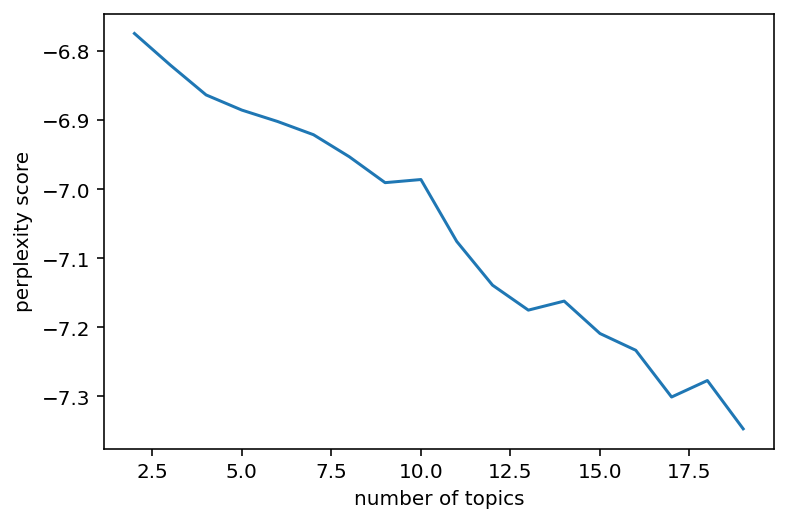

In [21]:
perp_visual(min_rage_corpus, min_rage_dictionary)

coherence score는 높을수록, perplexity score는 낮을수록 모델의 개수가 최적이라는 뜻 -> 군집의 개수 = 12

In [22]:
ldamodel = gensim.models.ldamodel.LdaModel(min_rage_corpus, num_topics=12, alpha=0.1, id2word = min_rage_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, min_rage_corpus, min_rage_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.038794  0.055280       1        1  22.727133
6      0.035858  0.064902       2        1  10.716924
4      0.065497 -0.034614       3        1   9.247630
8     -0.040993 -0.006800       4        1   8.990166
3     -0.090410  0.016361       5        1   8.795430
9      0.009507  0.048405       6        1   8.169154
5     -0.066973 -0.040256       7        1   7.671184
11     0.008080  0.036452       8        1   7.154035
2      0.035493 -0.011114       9        1   5.590503
7      0.024749 -0.045001      10        1   4.375328
0      0.041846 -0.078270      11        1   4.186015
10    -0.061446 -0.005346      12        1   2.376502, topic_info=     Term         Freq        Total Category  logprob  loglift
313   장애인   169.000000   169.000000  Default  30.0000  30.0000
110    활동   154.000000   154.000000  Default  29.0000  29.0000
58   최저임금  1004.000000  1004.000000  Default  28.0000  28.0000
161    위원   212.000000   212.000000  Default  27.0000  27.0000
239    급여   168.000000   168.000000  Default  26.0000  26.0000
..    ...          ...          ...      ...      ...      ...
24     부담     2.650951   133.389130  Topic12  -5.4088  -0.1788
99     지급     2.852539   192.664215  Topic12  -5.3355  -0.4732
150    수준     2.480129   105.049866  Topic12  -5.4754  -0.0066
107    함안     2.745896   232.717087  Topic12  -5.3736  -0.7002
235    고용     2.466454   208.618408  Topic12  -5.4809  -0.6982

[885 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1347      1  0.083671   가격
1347      2  0.083671   가격
1347      3  0.251014   가격
1347      4  0.083671   가격
1347      5  0.083671   가격
...     ...       ...  ...
1087      9  0.085382   회의
1087     11  0.042691   회의
112       1  0.168454  후보자
112       6  0.336907  후보자
112       7  0.336907  후보자

[2654 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 5, 9, 4, 10, 6, 12, 3, 8, 1, 11])

?????

#### 3.3 정당별 토픽모델링

In [23]:
cond1 = min_rage['더불어민주당'] == 1
cond2 = min_rage['더불어시민당'] == 1

cond3 = min_rage['새누리당'] == 1
cond4 = min_rage['자유한국당'] == 1
cond5 = min_rage['미래통합당'] == 1
cond6 = min_rage['미래한국당'] == 1

cond7 = min_rage['정의당'] == 1

cond8 = min_rage['국민의당'] == 1

minzu = min_rage[cond1 | cond2]
mirae = min_rage[cond3 | cond4 | cond5 | cond6]
jeongwui = min_rage[cond7]
gookmin = min_rage[cond8]

print(minzu.shape)
print(mirae.shape)
print(jeongwui.shape)
print(gookmin.shape)

(126, 34)
(102, 34)
(25, 34)
(47, 34)


###### 3.3.1 민주당
- 더불어민주당 + 더불어시민당

In [46]:
def make_text_list(dataframe):
  min_rage_text_list = []
  for i in dataframe['의안명+제안이유']:
    min_rage_text_list.append(i)
  return min_rage_text_list

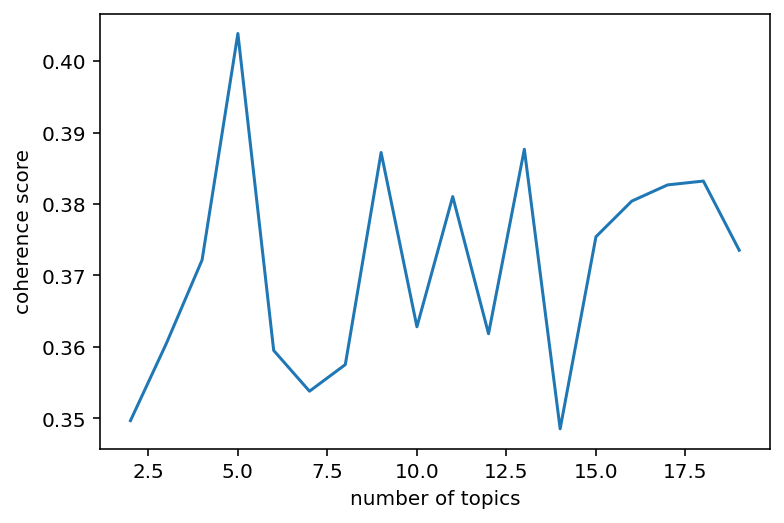

In [83]:
text_list = make_text_list(minzu)
min_rage_clean = Preproc(text_list)
min_rage_corpus, min_rage_dictionary, min_rage_cleanlist = make_corpus(min_rage_clean)
coh_visual(min_rage_corpus, min_rage_dictionary, min_rage_cleanlist)

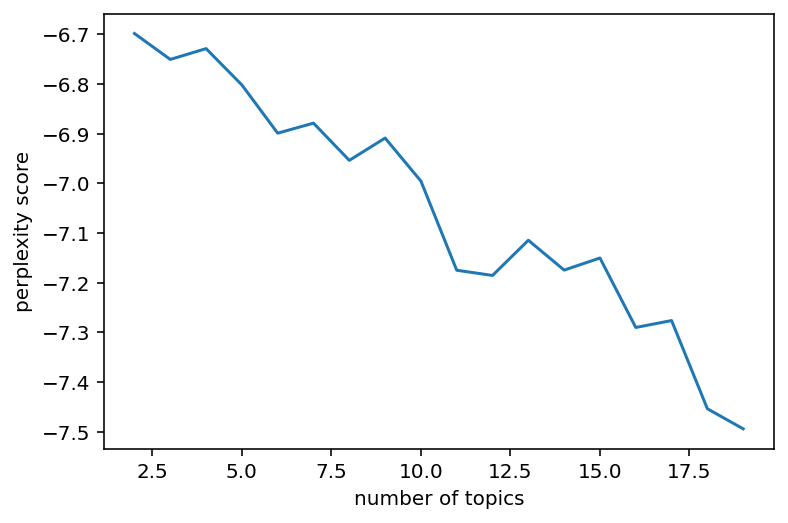

In [84]:
perp_visual(min_rage_corpus, min_rage_dictionary)

In [86]:
ldamodel = gensim.models.ldamodel.LdaModel(min_rage_corpus, num_topics=5, alpha=0.1, id2word = min_rage_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, min_rage_corpus, min_rage_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.019189  0.016867       1        1  36.952843
2      0.064614  0.005887       2        1  28.787807
0      0.007645  0.031520       3        1  15.259767
1     -0.083774  0.017892       4        1  10.365849
3     -0.007674 -0.072167       5        1   8.633733, topic_info=      Term        Freq       Total Category  logprob  loglift
438     계약   79.000000   79.000000  Default  30.0000  30.0000
190     활동  132.000000  132.000000  Default  29.0000  29.0000
33      조건   35.000000   35.000000  Default  28.0000  28.0000
8       급여  131.000000  131.000000  Default  27.0000  27.0000
12      보험   50.000000   50.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
251     제호    4.778023   45.676952   Topic5  -5.5091   0.1919
127  최저임금법    5.154201   68.941505   Topic5  -5.4334  -0.1440
2       고용    5.387929  124.378349   Topic5  -5.3890  -0.6897
247     적용    4.982984   74.681770   Topic5  -5.4671  -0.2577
14      부담    4.661793   47.852840   Topic5  -5.5338   0.1208

[379 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1327      1  0.641792   가맹
1327      5  0.275054   가맹
1005      1  0.189418   가사
1005      2  0.189418   가사
1005      3  0.568254   가사
...     ...       ...  ...
846       1  0.165553   훈련
846       2  0.110369   훈련
846       3  0.165553   훈련
846       4  0.441475   훈련
846       5  0.110369   훈련

[893 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 2, 4])

topic 4 병역
topic 5 골목상권

###### 3.3.2 통합당

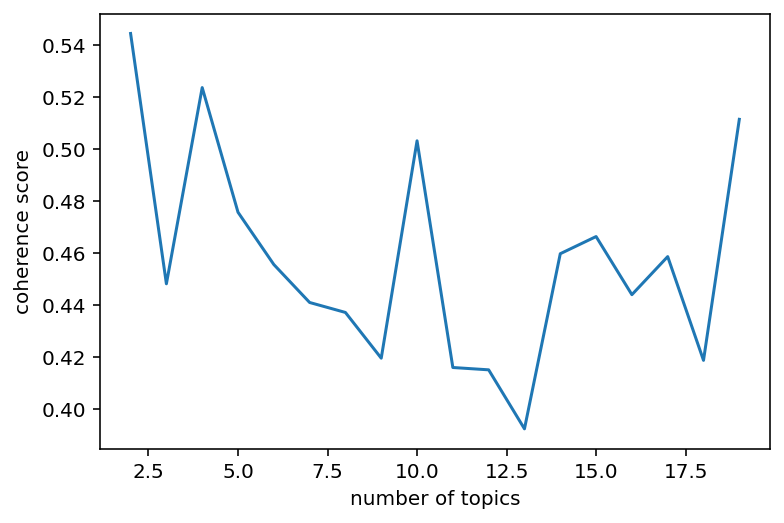

In [91]:
text_list = make_text_list(mirae)
min_rage_clean = Preproc(text_list)
min_rage_corpus, min_rage_dictionary, min_rage_cleanlist = make_corpus(min_rage_clean)
coh_visual(min_rage_corpus, min_rage_dictionary, min_rage_cleanlist)

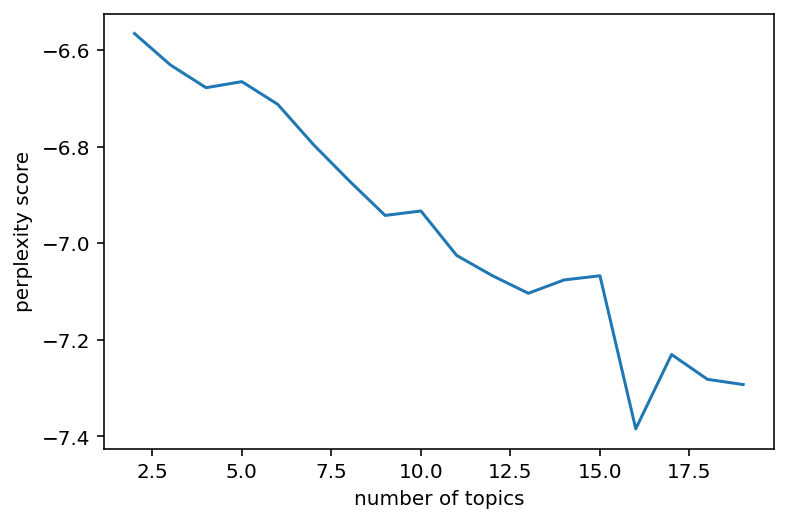

In [92]:
perp_visual(min_rage_corpus, min_rage_dictionary)

In [93]:
ldamodel = gensim.models.ldamodel.LdaModel(min_rage_corpus, num_topics=4, alpha=0.1, id2word = min_rage_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, min_rage_corpus, min_rage_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.059073 -0.000591       1        1  38.257713
0     -0.052221  0.027841       2        1  25.328773
2     -0.034403 -0.036148       3        1  22.628792
1      0.027551  0.008898       4        1  13.784729, topic_info=     Term        Freq       Total Category  logprob  loglift
58   최저임금  456.000000  456.000000  Default  30.0000  30.0000
762    위원  105.000000  105.000000  Default  29.0000  29.0000
217    결정   97.000000   97.000000  Default  28.0000  28.0000
263    임금  150.000000  150.000000  Default  27.0000  27.0000
480    세율   56.000000   56.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
38     업종    5.822629   37.616871   Topic4  -5.5449   0.1159
316    영향    5.356391   31.670769   Topic4  -5.6283   0.2045
247    소득    5.854741   54.449928   Topic4  -5.5394  -0.2484
168    고용    6.159643   77.867172   Topic4  -5.4886  -0.5554
99     지급    5.765766   59.372135   Topic4  -5.5547  -0.3503

[316 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1425      1  0.328196   간만
1425      2  0.656391   간만
1385      2  0.190034   감독
1385      3  0.570102   감독
776       1  0.199897   감액
...     ...       ...  ...
878       2  0.234538   환산
878       4  0.375262   환산
1238      1  0.251618   후단
1238      2  0.503237   후단
1220      1  0.895224   훈련

[637 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

topic 2 는 젊은층의 아르바이트  
topic 5 는 국가에서 지급해야할 임금에 대한 것 ??

###### 3.3.3 정의당

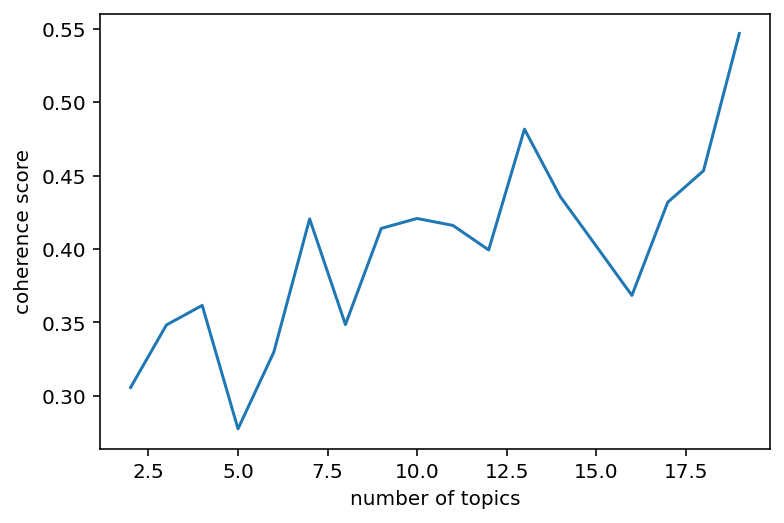

In [100]:
text_list = make_text_list(jeongwui)
min_rage_clean = Preproc(text_list)
min_rage_corpus, min_rage_dictionary, min_rage_cleanlist = make_corpus(min_rage_clean)
coh_visual(min_rage_corpus, min_rage_dictionary, min_rage_cleanlist)

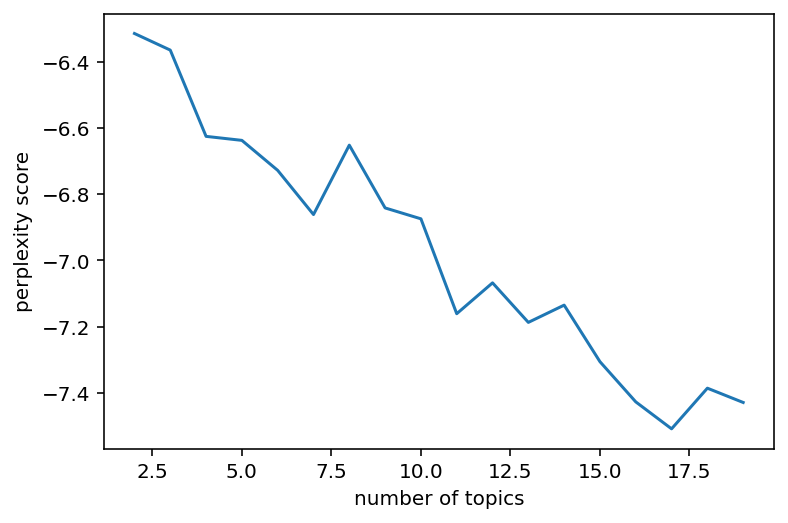

In [101]:
perp_visual(min_rage_corpus, min_rage_dictionary)

In [102]:
ldamodel = gensim.models.ldamodel.LdaModel(min_rage_corpus, num_topics=12, alpha=0.1, id2word = min_rage_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, min_rage_corpus, min_rage_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.007438  0.072444       1        1  22.202982
0      0.074857 -0.052936       2        1  12.231537
4      0.046740 -0.045151       3        1  11.450201
1      0.049908  0.027080       4        1  11.432822
5     -0.123623 -0.026436       5        1  10.136637
9     -0.007631 -0.034124       6        1   8.109561
2      0.022479  0.078803       7        1   7.317351
10    -0.035456 -0.063788       8        1   5.652748
11    -0.091019  0.000415       9        1   5.131718
8      0.016666  0.072679      10        1   3.874595
6      0.053596 -0.065458      11        1   2.367647
3      0.000920  0.036472      12        1   0.092203, topic_info=     Term       Freq      Total Category  logprob  loglift
316    계약  37.000000  37.000000  Default  30.0000  30.0000
76   최저임금  85.000000  85.000000  Default  29.0000  29.0000
124    사회  21.000000  21.000000  Default  28.0000  28.0000
346   서비스  12.000000  12.000000  Default  27.0000  27.0000
87     활동  11.000000  11.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
327    조건   0.015370  15.654995  Topic12  -5.0774   0.0628
496    위로   0.014031  14.188558  Topic12  -5.1685   0.0700
9    국회의원   0.012250  12.822426  Topic12  -5.3042   0.0355
62     임금   0.012505  33.864777  Topic12  -5.2837  -0.9151
199    생활   0.011732  10.889464  Topic12  -5.3475   0.1557

[696 rows x 6 columns], token_table=      Topic      Freq Term
term                      
315       4  0.478097   가맹
315       5  0.478097   가맹
333       3  0.361675   가치
333       4  0.542512   가치
428       8  0.735795   간호
...     ...       ...  ...
723       4  0.469572   효율
426       7  0.196995   훈련
426       9  0.393991   훈련
88        2  0.678517   휴가
185       5  0.448929   휴직

[863 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 5, 2, 6, 10, 3, 11, 12, 9, 7, 4])

topic 1은 장애인과 관련  
topic 2는 임대료와 관련  
topic 3는 법  
topic 4는 청소년  
topic 6는 골목상권

topic 1은 병역사고?   
topic 2는 국회의원의 보수  
topic 5는 장애인
topic 9는 병역
topic 10은 여성? 성노동?

###### 3.3.4 국민의당

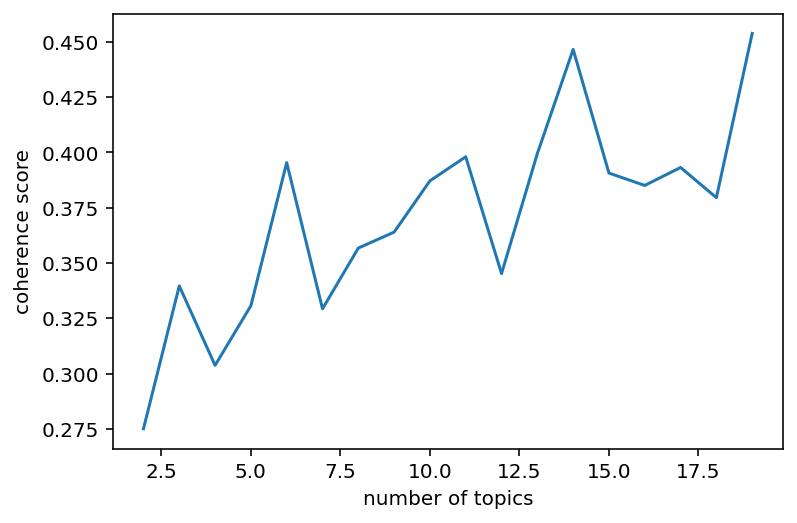

In [107]:
text_list = make_text_list(gookmin)
min_rage_clean = Preproc(text_list)
min_rage_corpus, min_rage_dictionary, min_rage_cleanlist = make_corpus(min_rage_clean)
coh_visual(min_rage_corpus, min_rage_dictionary, min_rage_cleanlist)

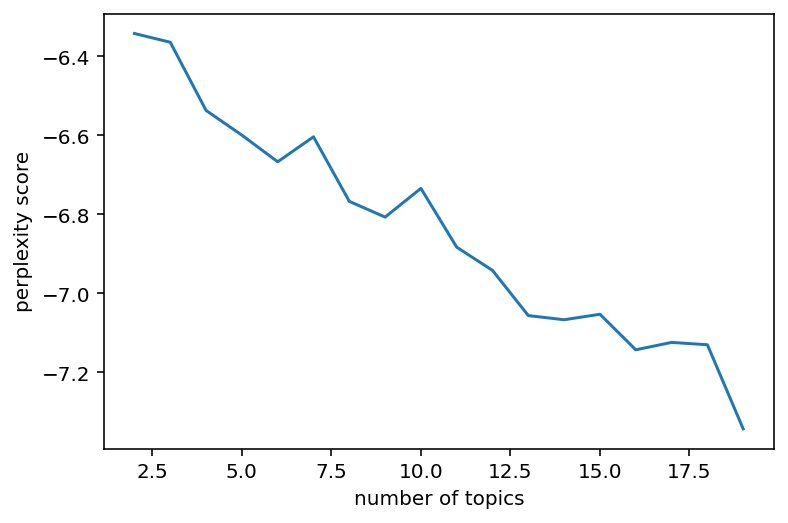

In [108]:
perp_visual(min_rage_corpus, min_rage_dictionary)

In [109]:
ldamodel = gensim.models.ldamodel.LdaModel(min_rage_corpus, num_topics=14, alpha=0.1, id2word = min_rage_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, min_rage_corpus, min_rage_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.088358  0.000044       1        1  24.436243
5      0.036578  0.100569       2        1  17.104792
4      0.025599  0.014023       3        1  10.291807
6     -0.033637  0.112449       4        1   7.693686
10     0.086818 -0.116936       5        1   6.802125
2     -0.105621 -0.033650       6        1   5.885561
1     -0.070698 -0.007714       7        1   5.302790
13     0.114543 -0.027555       8        1   4.581062
7      0.139392  0.061836       9        1   4.548582
9     -0.043065 -0.025990      10        1   3.608653
11    -0.092935 -0.007022      11        1   3.481171
12    -0.013281  0.032362      12        1   2.918255
8     -0.007441 -0.072757      13        1   2.083035
0      0.052106 -0.029658      14        1   1.262247, topic_info=     Term        Freq       Total Category  logprob  loglift
12    근로자   95.000000   95.000000  Default  30.0000  30.0000
74   최저임금  183.000000  183.000000  Default  29.0000  29.0000
172    구직   29.000000   29.000000  Default  28.0000  28.0000
105    위원   32.000000   32.000000  Default  27.0000  27.0000
142    급여   34.000000   34.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
3      개정    0.361173   41.284286  Topic14  -4.9932  -0.3666
769    촉진    0.301871   20.236368  Topic14  -5.1726   0.1670
149    보험    0.284516   14.567171  Topic14  -5.2318   0.4365
63     제조    0.300727   45.531448  Topic14  -5.1764  -0.6477
705    이익    0.263898    7.241544  Topic14  -5.3070   1.0602

[821 rows x 6 columns], token_table=      Topic      Freq Term
term                      
199       1  0.294468   가액
199       9  0.294468   가액
798       1  0.404215  가운데
798       5  0.404215  가운데
738       3  0.239130   가입
...     ...       ...  ...
819       1  0.394493   후납
819       5  0.394493   후납
306       1  0.320097   후단
306       6  0.320097   후단
171       5  0.581719   휴업

[1218 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 5, 7, 11, 3, 2, 14, 8, 10, 12, 13, 9, 1])

topic 10은 양육  
topic 11은 중소기업

## 4. '최저임금'과 관련된 키워드 분석
- 사용된 키워드는 최저임금, 임금, 일급, 시급, 생활임금

In [61]:
print("'최저임금' 키워드만 들어간 법안의 수 ",min_rage.shape)
print("'최저임금과 관련된 키워드'를 포함했을 경우 법안의 수", rage.shape)

'최저임금' 키워드만 들어간 법안의 수  (231, 34)
'최저임금과 관련된 키워드'를 포함했을 경우 법안의 수 (1130, 34)


#### 4.1 법안은 언제 발의됐는가

Text(0.5, 1.0, '월별 최저임금 관련 법안 발의 건수')

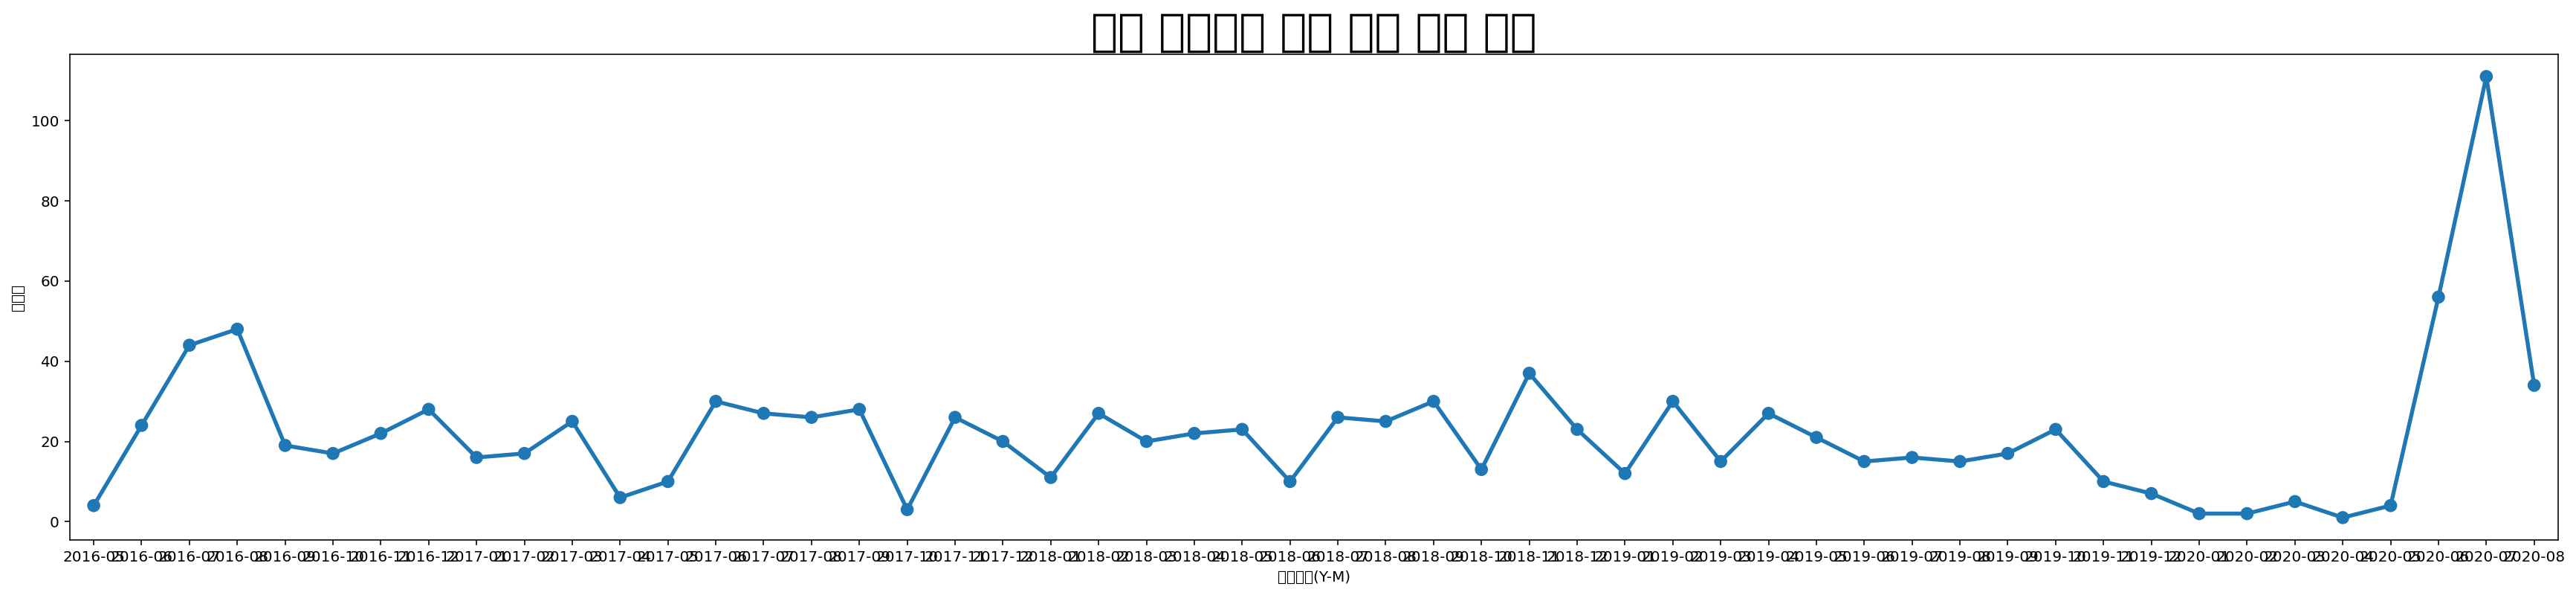

In [62]:
rage_proposer_date = pd.DataFrame(rage.groupby('제안일자(Y-M)')['의안명'].count())
plt.figure(figsize = (30,6))
sns.pointplot(data = rage_proposer_date, x = rage_proposer_date.index, y='의안명')
plt.title('월별 최저임금 관련 법안 발의 건수', fontsize=30)

크게 다르지않지만 __21대 국회의 시작__과 함께 폭증한 관련법

#### 4.2 법안 토픽모델링

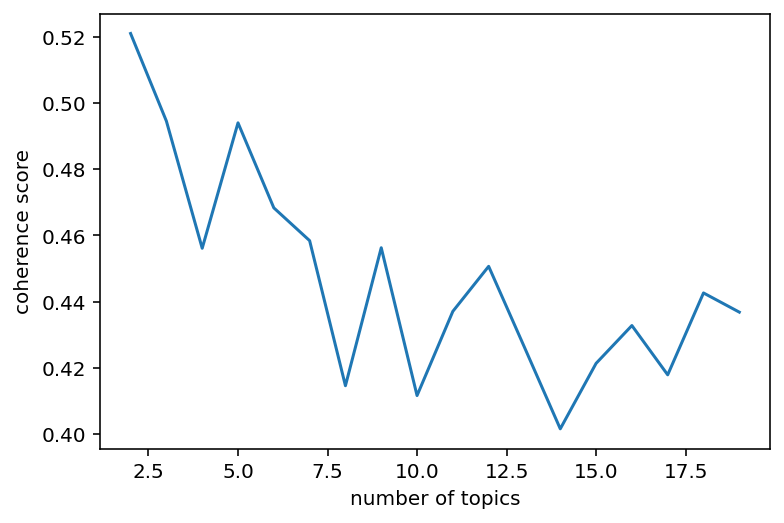

CPU times: user 52.8 s, sys: 2.9 s, total: 55.7 s
Wall time: 52.3 s


In [110]:
text_list = make_text_list(rage)
min_rage_clean = Preproc(text_list)
min_rage_corpus, min_rage_dictionary, min_rage_cleanlist = make_corpus(min_rage_clean)
%time coh_visual(min_rage_corpus, min_rage_dictionary, min_rage_cleanlist)

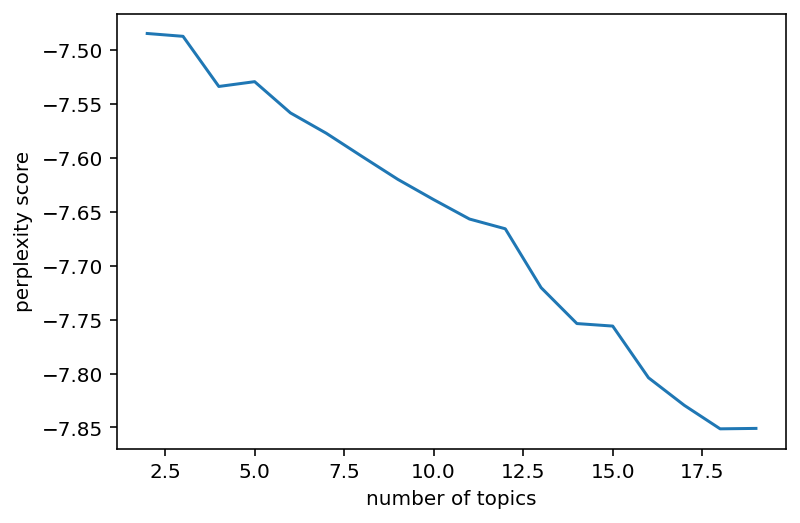

In [111]:
perp_visual(min_rage_corpus, min_rage_dictionary)

In [112]:
ldamodel = gensim.models.ldamodel.LdaModel(min_rage_corpus, num_topics=5, alpha=0.1, id2word = min_rage_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, min_rage_corpus, min_rage_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.003424 -0.022172       1        1  25.570673
1      0.030746 -0.007445       2        1  24.136698
4     -0.013990  0.025227       3        1  18.310926
2     -0.031766 -0.013999       4        1  16.610102
3      0.011586  0.018389       5        1  15.371604, topic_info=      Term         Freq        Total Category  logprob  loglift
565   최저임금   985.000000   985.000000  Default  30.0000  30.0000
480     임금  1539.000000  1539.000000  Default  29.0000  29.0000
479     위원   301.000000   301.000000  Default  28.0000  28.0000
461     고용   823.000000   823.000000  Default  27.0000  27.0000
673     지급   783.000000   783.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
1335    급여    63.609329   359.656799   Topic5  -5.9069   0.1403
565   최저임금    70.908104   985.861572   Topic5  -5.7983  -0.7595
461     고용    67.121773   823.945374   Topic5  -5.8532  -0.6349
71       이    65.278961   536.250977   Topic5  -5.8810  -0.2333
35      보호    64.028549   570.187561   Topic5  -5.9004  -0.3140

[456 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2073      1  0.105644   가맹
2073      2  0.558405   가맹
2073      3  0.226380   가맹
2073      4  0.045276   가맹
2073      5  0.075460   가맹
...     ...       ...  ...
605       1  0.154455   휴가
605       2  0.334652   휴가
605       3  0.102970   휴가
605       4  0.108118   휴가
605       5  0.293464   휴가

[1207 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 4])

topic1 은 군대
topic3 은 어린이, 양육

In [115]:
rage

,의안번호,의안명,제안자구분,제안회기,제안이유,소관위원회,제안정당,법률공포여부,개혁보수신당,국민의당,기본소득당,대안신당,대한애국당,더불어민주당,더불어시민당,무소속,미래를향한전진4.0,미래통합당,미래한국당,민생당,민주평화당,민중당,바른미래당,바른정당,새누리당,새로운보수당,새민중정당,시대전환,열린민주당,우리공화당,자유한국당,정의당,의안명+제안이유,제안일자(Y-M)
31,2024963,정보통신망 이용촉진 및 정보보호 등에 관한 법률 일부개정법률안,위원장,제20대 (2016~2020) 제378회,의 가 현행법상 금지되는 정보통신망 침해행위에 최근 정보통신망의 정상적인 보호 인...,과학기술정보방송통신위원회,['더불어민주당'],공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,정보통신망 이용촉진 및 정보보호 등에 관한 법률 일부개정법률안 의 가 현행법상 금...,2020-05
33,2024961,국가정보화 기본법 전부개정법률안,위원장,제20대 (2016~2020) 제378회,대안의 최근 우리 사회는 인공지능 데이터 G 등 첨단기술의 혁신적 발전으로 초...,과학기술정보방송통신위원회,['더불어민주당'],공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,국가정보화 기본법 전부개정법률안 대안의 최근 우리 사회는 인공지능 데이터 G ...,2020-05
40,2024954,건설기술 진흥법 일부개정법률안,위원장,제20대 (2016~2020) 제378회,의 건설기술인 교육 훈련은 기술인의 자질 향상을 위해 년 도입되었으나 전통적인 건...,국토교통위원회,['더불어민주당'],공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,건설기술 진흥법 일부개정법률안 의 건설기술인 교육 훈련은 기술인의 자질 향상을 위해...,2020-05
60,2024927,산업안전보건법 일부개정법률안,의원,제20대 (2016~2020) 제377회,년 월 하청업체에서 홀로 일하던 노동자의 죽음을 계기로 년 월 일부터 모든 근로자...,환경노동위원회,"['더불어민주당', '미래통합당', '미래한국당']",공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,산업안전보건법 일부개정법률안 년 월 하청업체에서 홀로 일하던 노동자의 죽음을 계기로...,2020-05
69,2024917,양성평등기본법 일부개정법률안,위원장,제20대 (2016~2020) 제377회,의 년부터 양성평등실무위원회가 기존 중앙행정기관 외에 지자체 소관 위원회도 심의하게...,여성가족위원회,['더불어민주당'],공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,양성평등기본법 일부개정법률안 의 년부터 양성평등실무위원회가 기존 중앙행정기관 외에 ...,2020-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25793,2100173,상가건물 임대차보호법 일부개정법률안,의원,제21대 (2020~2024) 제378회,전 세계를 강타하고 있는 코로나의 대유행으로 지난 분기 월의 실업자는 만 천명 일...,법제사법위원회,['더불어민주당'],NaN,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,상가건물 임대차보호법 일부개정법률안 전 세계를 강타하고 있는 코로나의 대유행으로 지...,2020-06
25795,2100171,조세특례제한법 일부개정법률안,의원,제21대 (2020~2024) 제378회,최근 확산되고 있는 코로나바이러스감염증 와 같은 감염병의 예방 등을 위한 자가격리 ...,기획재정위원회,['미래통합당'],NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,조세특례제한법 일부개정법률안 최근 확산되고 있는 코로나바이러스감염증 와 같은 감염병...,2020-06
25867,2100053,농지법 일부개정법률안,의원,제21대 (2020~2024) 제378회,날로 심각해지는 미세먼지 기후변화 등 환경문제 해결을 위해 재생에너지를 지금보...,농림축산식품해양수산위원회,['더불어민주당'],NaN,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,농지법 일부개정법률안 날로 심각해지는 미세먼지 기후변화 등 환경문제 해결을 위...,2020-06
25899,2100010,상가건물 임대차보호법 일부개정법률안,의원,제21대 (2020~2024) 제378회,코로나 로 인해 국민경제가 심각한 위기 상황에 처해 있음 특히 감염병 확산 방...,법제사법위원회,['미래통합당'],NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,상가건물 임대차보호법 일부개정법률안 코로나 로 인해 국민경제가 심각한 위기 상황...,2020-06


## 5. 코로나 관련 키워드 뽑아내기

In [66]:
## '산재', '과로사' 등과 같이 쓰이는 단어 목록
print(model.wv.most_similar('감염병'))

NameError: ignored

In [67]:
keyword = r'.*(감염병|감염증|전염병|방역).*'
covid = bill_df[bill_df['의안명'].str.match(keyword) | bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
print(covid.shape)
covid.head()

(509, 34)


,의안번호,의안명,제안자구분,제안회기,제안이유,소관위원회,제안정당,법률공포여부,개혁보수신당,국민의당,기본소득당,대안신당,대한애국당,더불어민주당,더불어시민당,무소속,미래를향한전진4.0,미래통합당,미래한국당,민생당,민주평화당,민중당,바른미래당,바른정당,새누리당,새로운보수당,새민중정당,시대전환,열린민주당,우리공화당,자유한국당,정의당,의안명+제안이유,제안일자(Y-M)
56,2024935,출입국관리법 일부개정법률안,위원장,제20대 (2016~2020) 제378회,출입국 전 과정에서 지문 얼굴을 비롯하여 홍채 손바닥 정맥 등 생체정보를 이용...,법제사법위원회,['더불어민주당'],공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,출입국관리법 일부개정법률안 출입국 전 과정에서 지문 얼굴을 비롯하여 홍채 손바...,2020-05
96,2024888,생명공학육성법 일부개정법률안,위원장,제20대 (2016~2020) 제377회,의 생명공학은 고령화 감염병 식량안보 기후변화 등 인류가 당면한 문제들을 해결...,과학기술정보방송통신위원회,['더불어민주당'],공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,생명공학육성법 일부개정법률안 의 생명공학은 고령화 감염병 식량안보 기후변화 등...,2020-04
109,2024873,조세특례제한법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나의 국내 확산 이후 강력한 방역 대응 과정에서 소...,기획재정위원회,['미래통합당'],미공포,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,조세특례제한법 일부개정법률안 코로나바이러스감염증 이하 코로나의 국내 확산 이후 ...,2020-04
110,2024872,조세특례제한법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나의 국내 확산이 장기화됨으로써 경제활동 위축과 실...,기획재정위원회,"['무소속', '더불어시민당', '민생당']",미공포,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,조세특례제한법 일부개정법률안 코로나바이러스감염증 이하 코로나의 국내 확산이 장기...,2020-04
111,2024871,부가가치세법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나 라 함의 국내 확산이 장기화됨으로써 경제활동 ...,기획재정위원회,"['무소속', '더불어시민당', '민생당']",미공포,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,부가가치세법 일부개정법률안 코로나바이러스감염증 이하 코로나 라 함의 국내 확산...,2020-04


In [68]:
covid_proposer_date = pd.DataFrame(covid.groupby('제안일자(Y-M)')['의안명'].count())
covid_proposer_date.head()

,의안명
제안일자(Y-M),
2016-06,4
2016-07,2
2016-08,5
2016-09,7
2016-10,3


Text(0.5, 1.0, '월별 감영병 관련 법안 발의 건수')

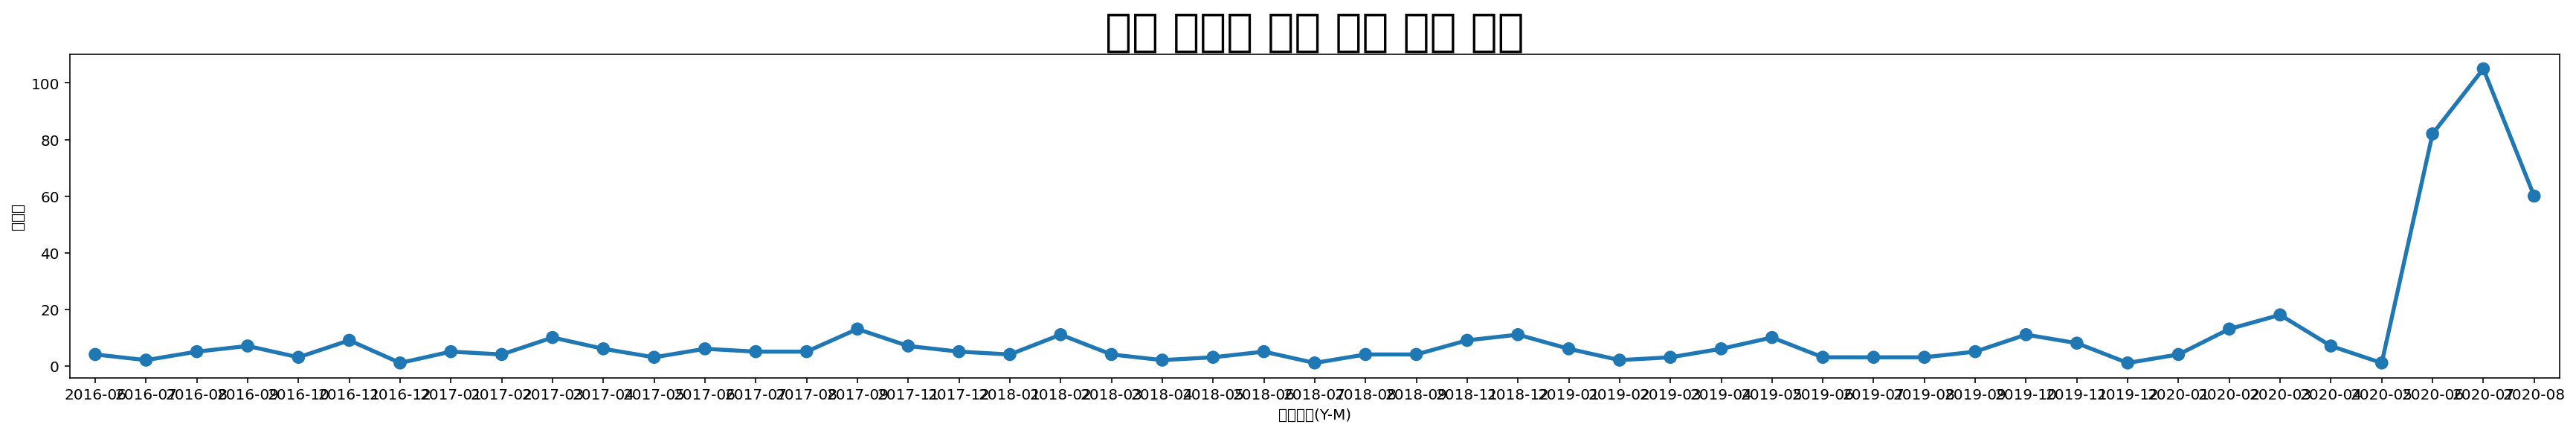

In [69]:
plt.figure(figsize = (30,4))
sns.pointplot(data = covid_proposer_date, x=covid_proposer_date.index, y='의안명')
plt.title('월별 감영병 관련 법안 발의 건수', fontsize=30)

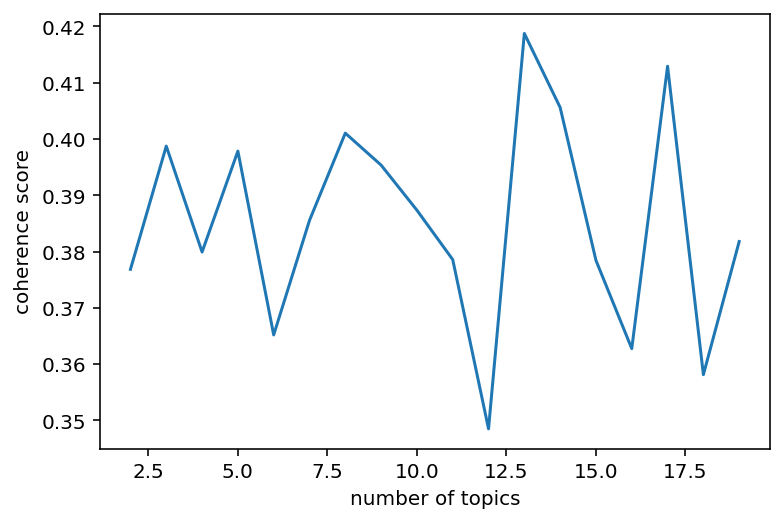

CPU times: user 20.9 s, sys: 26.9 ms, total: 20.9 s
Wall time: 20.9 s


In [70]:
text_list = make_text_list(covid)
covid_clean = Preproc(text_list)
covid_corpus, covid_dictionary, covid_cleanlist = make_corpus(covid_clean)
%time coh_visual(covid_corpus, covid_dictionary, covid_cleanlist)

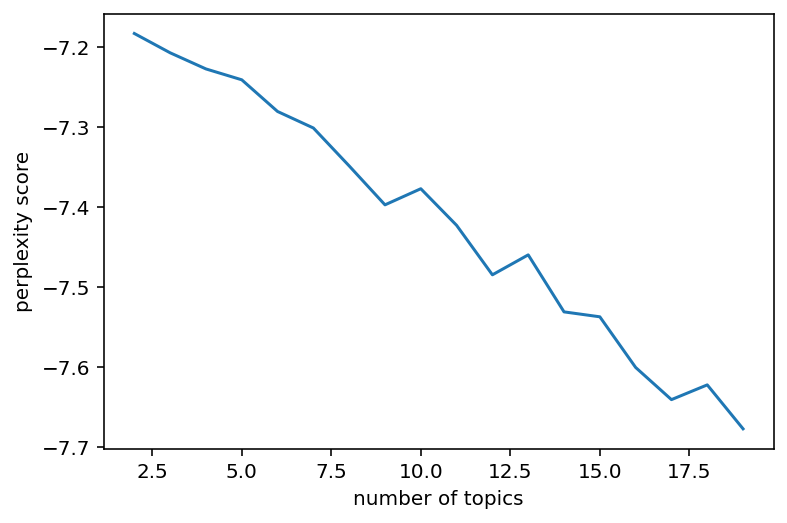

In [71]:
perp_visual(covid_corpus, covid_dictionary)

In [78]:
ldamodel = gensim.models.ldamodel.LdaModel(covid_corpus, num_topics=13, alpha=0.1, id2word = covid_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, covid_corpus, covid_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.046283 -0.014132       1        1  14.264674
0      0.035677  0.046805       2        1  11.209932
3      0.016310 -0.039236       3        1   9.812586
11     0.033969 -0.014156       4        1   9.537320
6      0.001928  0.026682       5        1   8.963927
2     -0.070577 -0.070105       6        1   8.337685
4      0.008259 -0.025381       7        1   6.590100
8      0.037190 -0.030872       8        1   6.579517
5     -0.010181  0.067612       9        1   6.326998
9      0.036126 -0.009112      10        1   5.718457
10    -0.057573 -0.036749      11        1   5.521164
7     -0.110813  0.054984      12        1   4.901273
1      0.033401  0.043659      13        1   2.236380, topic_info=      Term         Freq        Total Category  logprob  loglift
1098    가축   452.000000   452.000000  Default  30.0000  30.0000
1      감염병  1002.000000  1002.000000  Default  29.0000  29.0000
753    전염병   279.000000   279.000000  Default  28.0000  28.0000
162   기후변화   105.000000   105.000000  Default  27.0000  27.0000
106     제조   910.000000   910.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
1100    농가     4.314334    90.922409  Topic13  -5.6591   0.7522
92      임안     5.192883   245.291061  Topic13  -5.4738  -0.0548
167     대응     4.777283   200.052490  Topic13  -5.5572   0.0656
241     의료     5.166629   496.034119  Topic13  -5.4788  -0.7641
326     상황     4.651645   248.773132  Topic13  -5.5838  -0.1790

[984 rows x 6 columns], token_table=      Topic      Freq Term
term                      
831       1  0.031664   가격
831       2  0.031664   가격
831       3  0.063327   가격
831       4  0.189982   가격
831       5  0.031664   가격
...     ...       ...  ...
554       4  0.066337   휴업
554       5  0.066337   휴업
554       8  0.066337   휴업
554      10  0.066337   휴업
554      13  0.066337   휴업

[3696 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 1, 4, 12, 7, 3, 5, 9, 6, 10, 11, 8, 2])

###### 코로나로만

In [73]:
keyword = r'.*(코로나).*'
covid_df = bill_df[bill_df['의안명'].str.match(keyword) | bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
print(covid_df.shape)
covid_df.head()

(417, 34)


,의안번호,의안명,제안자구분,제안회기,제안이유,소관위원회,제안정당,법률공포여부,개혁보수신당,국민의당,기본소득당,대안신당,대한애국당,더불어민주당,더불어시민당,무소속,미래를향한전진4.0,미래통합당,미래한국당,민생당,민주평화당,민중당,바른미래당,바른정당,새누리당,새로운보수당,새민중정당,시대전환,열린민주당,우리공화당,자유한국당,정의당,의안명+제안이유,제안일자(Y-M)
109,2024873,조세특례제한법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나의 국내 확산 이후 강력한 방역 대응 과정에서 소...,기획재정위원회,['미래통합당'],미공포,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,조세특례제한법 일부개정법률안 코로나바이러스감염증 이하 코로나의 국내 확산 이후 ...,2020-04
110,2024872,조세특례제한법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나의 국내 확산이 장기화됨으로써 경제활동 위축과 실...,기획재정위원회,"['무소속', '더불어시민당', '민생당']",미공포,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,조세특례제한법 일부개정법률안 코로나바이러스감염증 이하 코로나의 국내 확산이 장기...,2020-04
111,2024871,부가가치세법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나 라 함의 국내 확산이 장기화됨으로써 경제활동 ...,기획재정위원회,"['무소속', '더불어시민당', '민생당']",미공포,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,부가가치세법 일부개정법률안 코로나바이러스감염증 이하 코로나 라 함의 국내 확산...,2020-04
125,2024851,조세특례제한법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나의 국내 확산 이후 강력한 방역 대응 과정에서 소...,기획재정위원회,"['더불어민주당', '더불어시민당']",미공포,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,조세특례제한법 일부개정법률안 코로나바이러스감염증 이하 코로나의 국내 확산 이후 ...,2020-04
132,2024833,재난 및 안전관리 기본법 일부개정법률안,의원,제20대 (2016~2020) 제376회,법은 대규모 재난의 대응 복구를 위하여 중앙재난안전대책본부이하 중앙대책본부 라 한...,행정안전위원회,['더불어민주당'],미공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,재난 및 안전관리 기본법 일부개정법률안 법은 대규모 재난의 대응 복구를 위하여 중앙...,2020-04


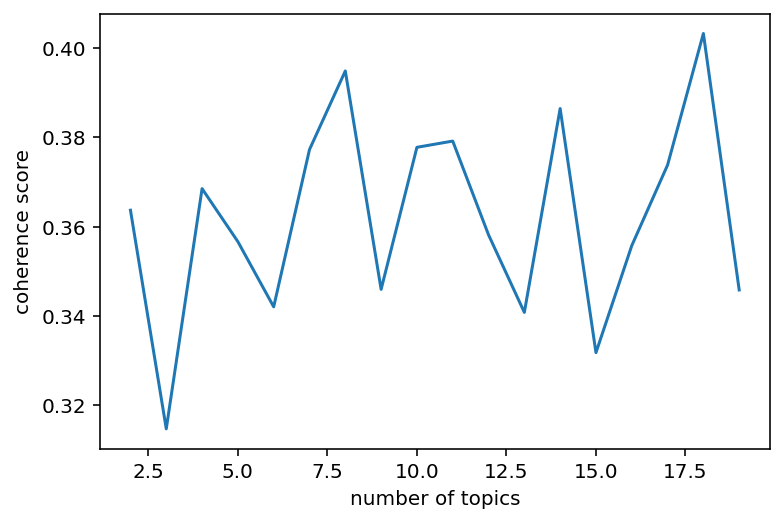

CPU times: user 17.5 s, sys: 21.1 ms, total: 17.5 s
Wall time: 17.5 s


In [74]:
text_list = make_text_list(covid_df)
covid_df_clean = Preproc(text_list)
covid_df_corpus, covid_df_dictionary, covid_df_cleanlist = make_corpus(covid_df_clean)
%time coh_visual(covid_df_corpus, covid_df_dictionary, covid_df_cleanlist)

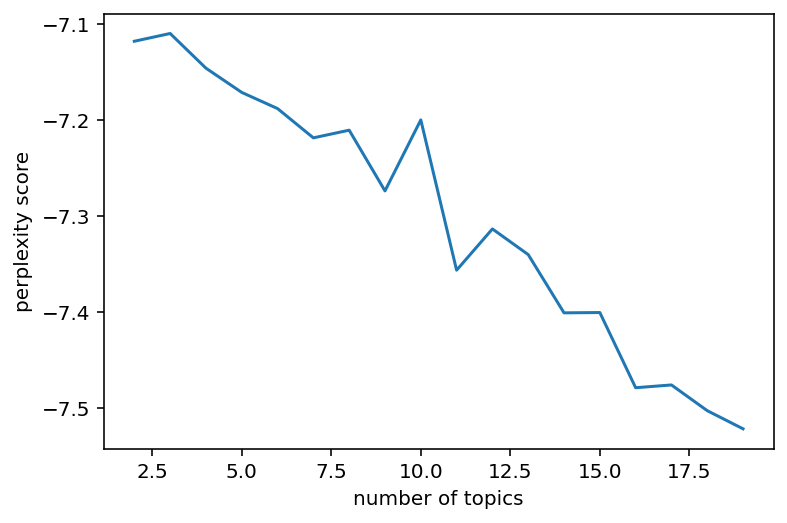

In [75]:
perp_visual(covid_df_corpus, covid_df_dictionary)

In [79]:
ldamodel = gensim.models.ldamodel.LdaModel(covid_df_corpus, num_topics=17, alpha=0.1, id2word = covid_df_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, covid_df_corpus, covid_df_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.029228 -0.045815       1        1  13.947694
13    -0.026134  0.049439       2        1   9.269149
14    -0.063494  0.033236       3        1   8.826426
15    -0.079944 -0.110142       4        1   8.040620
6      0.108566  0.016973       5        1   7.270907
3     -0.038374  0.010868       6        1   7.245457
11     0.011434  0.027183       7        1   5.962987
7     -0.020797  0.029495       8        1   5.644457
4      0.030038 -0.021695       9        1   5.370277
16     0.035295 -0.093495      10        1   4.243830
9     -0.070066  0.011906      11        1   4.045111
10    -0.027400  0.000236      12        1   3.986509
8     -0.001655  0.029558      13        1   3.826187
5      0.061099 -0.026079      14        1   3.614263
12     0.075375  0.022310      15        1   3.498873
0     -0.021618  0.016520      16        1   3.342480
2     -0.001552  0.049502      17        1   1.864767, topic_info=         Term        Freq       Total Category  logprob  loglift
650      벤처기업  221.000000  221.000000  Default  30.0000  30.0000
1096       비대  219.000000  219.000000  Default  29.0000  29.0000
662        중소  219.000000  219.000000  Default  28.0000  28.0000
998        수업  123.000000  123.000000  Default  27.0000  27.0000
218        산업  243.000000  243.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
178        사회    3.306520  150.232147  Topic17  -5.5620   0.1657
1         감염증    3.203516  158.719086  Topic17  -5.5936   0.0791
52    코로나바이러스    3.200061  159.115616  Topic17  -5.5947   0.0756
994        대학    2.732005   68.943573  Topic17  -5.7528   0.7538
296        지역    3.244129  290.094238  Topic17  -5.5810  -0.5113

[1234 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2138      5  0.350188    가가
2138     15  0.350188    가가
1003      2  0.143825    가능
1003      4  0.143825    가능
1003      8  0.143825    가능
...     ...       ...   ...
455      11  0.034673    휴가
455      14  0.011558    휴가
455      16  0.011558    휴가
2803      1  0.686453  휴대전화
2231      6  0.358679    휴일

[4975 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 14, 15, 16, 7, 4, 12, 8, 5, 17, 10, 11, 9, 6, 13, 1, 3])